#### Import and ENV

In [2]:
import torch.nn as nn
import torch
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.datasets import CIFAR10
from torchmetrics import Accuracy
import importlib
# Local files
import data
importlib.reload(data)
import encoder
importlib.reload(encoder)
import decoder
importlib.reload(decoder)
import autoencoder
importlib.reload(autoencoder)
import training
importlib.reload(training)

# Random Seed
torch.manual_seed(0)

In [3]:
torch.cuda.is_available()

True

## **DataLoader**

In [4]:
# from data import get_datasets,dataset_to_dataloader
train_ds, val_ds, test_ds = data.get_datasets()
dataloader_train = data.dataset_to_dataloader(train_ds)
dataloader_test = data.dataset_to_dataloader(test_ds)
dataloader_val = data.dataset_to_dataloader(val_ds)

Files already downloaded and verified
Files already downloaded and verified


## **AutoEncoder Model**

### Some Initial Test

In [5]:
# # Pretrained model
# my_model = resnet18(pretrained=True)


In [6]:
# if torch.cuda.is_available():
#   my_model.to(torch.device('cuda:0'))

In [7]:
# def evaluate(model, dataloader):
#         """Compute the Accuracy of the test set
#         * Model (RestNet18 Module)
#         * Dataload
#         *Iterates through the DataLoader to calculate the  

#         """
#         val_acc = []
#         for X_batch, y_batch in dataloader:
#           if torch.cuda.is_available():
#             X_batch = X_batch.cuda()
#             y_pred = model(X_batch)
#             X_batch = X_batch.cpu()
#             y_pred = y_pred.cpu()
#           else: 
#             y_pred = model(X_batch)

#           y_pred_softmax = torch.softmax(y_pred, dim=0)
#           y_pred_arg_max = torch.argmax(y_pred_softmax, dim=1)

#           accuracy = Accuracy(task="multiclass", num_classes=10)
#           acc = accuracy(y_pred_arg_max,y_batch)
#           val_acc.append(acc)
#           # print("Model accuracy: %.2f%%" % (acc*100))
#         val_acc = np.array(val_acc)
#         avg_val_acc = np.mean(val_acc) 
#         print("Avg. Model accuracy: %.2f%%" % (avg_val_acc*100))

#         return avg_val_acc


In [8]:
# evaluate(my_model, dataloader_val)

In [9]:
# my_model.cpu()

## **Training** 

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder 
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoder = self.decoder(encoded)
        return decoder


In [11]:
bottle_neck = 64
encoder = encoder.resnet18(pretrained=False,num_classes=bottle_neck)
decoder = decoder.ResNet18Dec(z_dim=bottle_neck)
model = AutoEncoder(encoder=encoder, decoder= decoder).to(torch.device('cuda:0'))

In [12]:

# model = resnet18(pretrained=False).to(torch.device('cuda:0'))
# criterion =  nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
model, history = training.train(
    model,
    criterion,
    optimizer,
    dataloader_train,
    dataloader_val,
    save_file_name='auto-encoder-40.pt',
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Starting Training from Scratch.

Epoch: 1	100.00% complete. 146.00 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.3057 	Validation Loss: 0.3258
Epoch: 3	100.00% complete. 147.78 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.2364 	Validation Loss: 0.2587
Epoch: 5	100.00% complete. 148.87 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.2037 	Validation Loss: 0.4230
Epoch: 7	100.00% complete. 151.71 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.1850 	Validation Loss: 0.2661
Epoch: 9	100.00% complete. 163.92 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.1723 	Validation Loss: 0.2155
Epoch: 11	100.00% complete. 168.11 seconds elapsed in epoch.
Epoch: 11 	Training Loss: 0.1628 	Validation Loss: 0.2330


In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        with torch.no_grad():
          for t, m, s in zip(tensor, self.mean, self.std):
              t.mul_(s).add_(m)
              # The normalize code -> t.sub_(m).div_(s)
          return tensor

In [ ]:
from torchvision.utils import make_grid
unorm = UnNormalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616))

def peek_results(dataloader, model):
  for img,lb in dataloader:
    fig, ax = plt.subplots(figsize=(16,8))
    fig1, ax1 = plt.subplots(figsize=(16,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax1.set_xticks([]); ax1.set_yticks([])
    img_output = model(img.cuda()).cpu()
    ax.imshow(make_grid(unorm(img_output), nrow=16).permute(1,2,0))
    ax1.imshow(make_grid(img, nrow=16).permute(1,2,0))
    break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


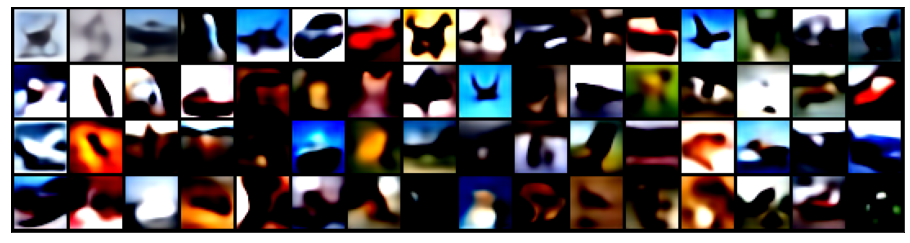

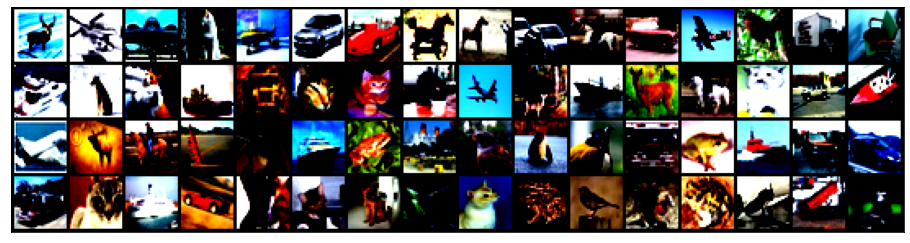

In [ ]:
peek_results(dataloader_test, model)